# Quora insincere question classifier
 Detect toxic content to improve online conversation

In [1]:
import pandas as pd
import numpy as np
import keras
import string

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn import preprocessing
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer

from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation


Using TensorFlow backend.


## 1. Load the Data

In [2]:
X_train = pd.read_csv("../input/train.csv")
X_train.head()
X_train.shape

test_set = pd.read_csv("../input/test.csv")
test_set.shape

(56370, 2)

Distribution of classes

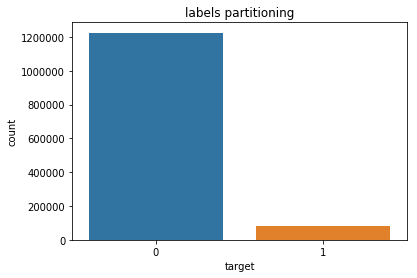

In [3]:
sns.countplot(X_train.target)
plt.title('labels partitioning')
plt.show()

Length of questions

(0, 400)

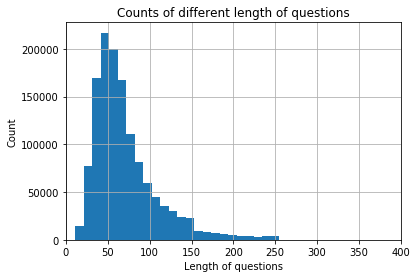

In [4]:
quest_lens = X_train.question_text.str.len()

quest_lens.hist(bins=100);

plt.title('Counts of different length of questions')
plt.ylabel('Count')
plt.xlabel('Length of questions')

plt.xlim(0, 400)
#plt.ylim(0,1200000)

Generate WordCloud

In [5]:
from functools import reduce
import operator

#Concatenate text 
text_forcloud = reduce(operator.concat, X_train["question_text"][:20000])

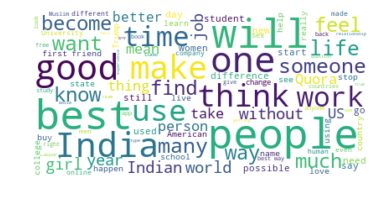

In [6]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_forcloud)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Select a subset from the whole dataset

In [7]:
X_train = X_train[:1000000]
#X_train.count()

#test_set = test_set[:1000]
#test_set.count()

Percentage of records of classes 0 and 1

In [8]:
n_records = X_train.shape[0]

non_toxic = X_train[X_train.target == 0].target.count()
toxic = X_train[X_train.target == 1].target.count()

print("total number of non_toxic Questions : {}".format(non_toxic))
print("total number of toxic Questions: {}".format(toxic))
print("percentage of non_toxic Questions : {}%".format( round(non_toxic/n_records*100) ) )
print("percentage of toxic Questions: {}%".format( round(toxic/n_records*100) ) ) 

total number of non_toxic Questions : 938210
total number of toxic Questions: 61790
percentage of non_toxic Questions : 94.0%
percentage of toxic Questions: 6.0%


## 2. Preprocess question_text column

Split the data into features and target label

In [9]:
y_train = X_train['target']
X_train = X_train['question_text']
#X_train = X_train.drop('target', axis = 1)


test_set = test_set['question_text']

Add space between text and punctuation

In [10]:
X_train = X_train.apply(lambda x: str(x).translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation })))

test_set = test_set.apply(lambda x: str(x).translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation })))

Remove Punctuation

In [11]:
puncts = ['£', '·', '©','®', '`', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

In [12]:
##check if a string contains a number 
#def hasNumbers(inputString):
 #   return any(char.isdigit() for char in inputString)

stemmer = SnowballStemmer("english")

#def stem_replaceNum(word):
#   if hasNumbers(word):
  #      word = 'replacedNum'
   # else:
    #word = stemmer.stem(word)
    #return word

def Remove_Stopwords(x):
    #try this : str(x).translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation }))
    #y = [ stemmer.stem(word) for word in x.split() ]#if (word.lower() not in stopwords.words('english') and word.lower() not in string.punctuation) ]
    y = [ word for word in x.split() if (word not in string.punctuation or puncts) ]

    #for word in x :print(word)
    return y


#X_train = X_train.apply(lambda x: Remove_Stopwords(x))
##X_train = X_train.drop('split_words', axis = 1)

#test_set = test_set.apply(lambda x: Remove_Stopwords(x))
##test_set = test_set.drop('split_words', axis = 1)

## 3. Next step is to aplly integer encoding

Define and fot tokenizer 

In [13]:
maxlen = 70
max_features = 50000
embed_size = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(test_set))

Transform text to sequence 

In [14]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train
test_set = tokenizer.texts_to_sequences(test_set)

Pad sequences and set a max length of words

In [15]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)

test_set = sequence.pad_sequences(test_set, maxlen=maxlen)

## 4. Create Embedding Matrix

In [16]:
EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
#Single asterisk as used in function declaration allows variable number of 
#arguments passed from calling environment. 
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print(emb_mean,emb_std )
embed_size = all_embs.shape[1]
print(embed_size)

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix_1 = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_1[i] = embedding_vector

del embeddings_index; #gc.collect() 


def load_fasttext(word_index):    
    EMBEDDING_FILE = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

#embedding_matrix_2 = load_fasttext(word_index)

def load_para(word_index):
    EMBEDDING_FILE = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

embedding_matrix_3 = load_para(word_index)


embedding_matrix = np.mean([embedding_matrix_1,  embedding_matrix_3], axis = 0)
#print(np.shape(embedding_matrix))

-0.005838499 0.48782197
300


## 5. Split features into training and validation set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.2,
                                                    random_state=28)

## 6. Define and train the model

Define the f1 score function

In [18]:
import keras.backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Define the model.

In [28]:
from keras.models import Model
from keras.layers import Input, Embedding, concatenate
from keras.layers import Conv1D
from keras.layers import *
from keras.models import *


filters = 128
    
inp = Input(shape=(maxlen, ))

embed = Embedding(max_features, embed_size, weights=[embedding_matrix_1], trainable=False)(inp)

x = embed
    
x = Conv1D(filters, 2, activation='relu')(x)
x = Dropout(0.1)(x)
    
x = Conv1D(filters, 2, activation='relu')(x)
x = Dropout(0.1)(x)
    
x = Conv1D(filters, 2, activation='relu')(x)
x = Dropout(0.1)(x)

x = Flatten()(x)
    
x = Dense(128, activation='relu')(x)
outp = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=outp)

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[f1])    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 70)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 70, 300)           15000000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 69, 128)           76928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 69, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 68, 128)           32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 68, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 67, 128)           32896     
__________

Training the model

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 2048
epochs = 7

early_stopping = EarlyStopping(patience=3, verbose=1, monitor='val_loss', mode='min')
model_checkpoint = ModelCheckpoint('./model.model', save_best_only=True, verbose=1, monitor='val_loss', mode='min')
#reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.0001, verbose=1)

hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=True)
model.save('./model.h5')

Train on 800000 samples, validate on 200000 samples
Epoch 1/7
800000/800000 [==============================] - 64s 80us/step - loss: 0.1363 - f1: 0.3718 - val_loss: 0.1185 - val_f1: 0.5794
Epoch 2/7
800000/800000 [==============================] - 63s 79us/step - loss: 0.1161 - f1: 0.5723 - val_loss: 0.1107 - val_f1: 0.6044
Epoch 3/7
800000/800000 [==============================] - 63s 79us/step - loss: 0.1085 - f1: 0.6003 - val_loss: 0.1080 - val_f1: 0.5952
Epoch 4/7
800000/800000 [==============================] - 63s 79us/step - loss: 0.1048 - f1: 0.6187 - val_loss: 0.1063 - val_f1: 0.6154
Epoch 5/7
800000/800000 [==============================] - 63s 79us/step - loss: 0.1018 - f1: 0.6329 - val_loss: 0.1068 - val_f1: 0.6170
Epoch 6/7
800000/800000 [==============================] - 63s 79us/step - loss: 0.0987 - f1: 0.6452 - val_loss: 0.1060 - val_f1: 0.6347
Epoch 7/7
800000/800000 [==============================] - 63s 79us/step - loss: 0.0958 - f1: 0.6571 - val_loss: 0.1060 - val_

## 7. Model evaluation

In [30]:
score = model.evaluate(X_test, y_test.values, verbose=1)
print("F1 score: ", score[1])

200000/200000 [==============================] - 19s 96us/step
F1 score:  0.5008809382915497


Define F1 Plotting function

In [31]:
import matplotlib.pyplot as plt

def plot_training_and_validation(acc, val_acc, loss, val_loss):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Plot f1-score and training loss of the validation set 

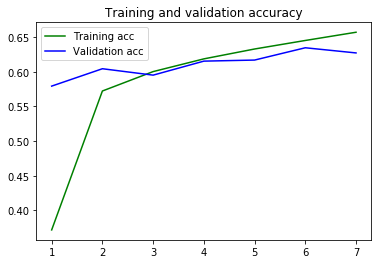

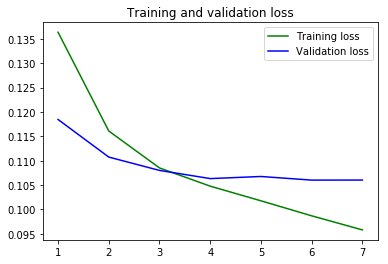

In [32]:
# define plotting metrics
acc = hist.history['f1']
val_acc = hist.history['val_f1']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
# plot model training and validation accuracy and loss
plot_training_and_validation(acc, val_acc, loss, val_loss)

In [33]:
from sklearn import metrics
pred_val_y_5 = model.predict([X_test], batch_size=1024, verbose=1)
thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(y_test, (pred_val_y_5 > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

y_pred_5 = model.predict(test_set, batch_size=1024, verbose=True)

200000/200000 [==============================] - 5s 27us/step
F1 score at threshold 0.1 is 0.5798899181098135
F1 score at threshold 0.11 is 0.5880185852143073
F1 score at threshold 0.12 is 0.5958654008201787
F1 score at threshold 0.13 is 0.6026620867325032
F1 score at threshold 0.14 is 0.607976710334789
F1 score at threshold 0.15 is 0.6127027346987096
F1 score at threshold 0.16 is 0.617320369645706
F1 score at threshold 0.17 is 0.6209763702503591
F1 score at threshold 0.18 is 0.6248528044623489
F1 score at threshold 0.19 is 0.6290216265419505
F1 score at threshold 0.2 is 0.6317196600782965
F1 score at threshold 0.21 is 0.6350928167877321
F1 score at threshold 0.22 is 0.6387989402413894
F1 score at threshold 0.23 is 0.6414869297286552
F1 score at threshold 0.24 is 0.6423151816289532
F1 score at threshold 0.25 is 0.6434800312171286
F1 score at threshold 0.26 is 0.6454029902045024
F1 score at threshold 0.27 is 0.6476925215457325
F1 score at threshold 0.28 is 0.6495312335405036
F1 score at

## 8. Predicting on the test set 

Predict the test_set labels

In [34]:
test_pred = model.predict(test_set)
test_pred = (test_pred > best_thresh).astype(int)

Transform it into a dataframe

In [35]:
df = pd.DataFrame(data=test_pred)
#convert one hot encoded to original values
#df = df.idxmax(axis=1)

Save Predictions to Submission file

In [ ]:
#save to submission
submission = pd.read_csv("../input/sample_submission.csv")
submission['prediction'] = df
submission.to_csv('submission.csv', index=False)